In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import math

In [2]:
train_identity = pd.read_csv(r'train_identity.csv')
test_identity = pd.read_csv(r'test_identity.csv')
test_transaction = pd.read_csv(r'test_transaction.csv')
train_transaction = pd.read_csv(r'train_transaction.csv')

trainDF = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
testDF = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

#fixing timestamps
trainDF['TransactionDay'] = (trainDF['TransactionDT'] // 86400).astype(int)
trainDF['TransactionDayOfWeek'] = trainDF['TransactionDay'] % 7
trainDF['TransactionWeek'] = (trainDF['TransactionDT'] // 604800).astype(int)

mean_transaction_amt = trainDF['TransactionAmt'].mean()
std_transaction_amt = trainDF['TransactionAmt'].std()
trainDF['TransactionAmt_Zscore'] = (trainDF['TransactionAmt'] - mean_transaction_amt) / std_transaction_amt

reference_date = pd.Timestamp("2017-01-01")
trainDF['TransactionDate'] = trainDF['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))
trainDF['TransactionMonth'] = trainDF['TransactionDate'].dt.month

%store trainDF

Stored 'trainDF' (DataFrame)


# -------------------------------------------------------------------------------------

# PCA 1D and 2D

In [3]:
#PCA 1D
numeric_cols_train = trainDF.select_dtypes('number')
#separate isFraud into Y component of PCA
x1D = numeric_cols_train.fillna(numeric_cols_train.mean())
x1D.drop(['isFraud'], axis = 1)
y1D = trainDF['isFraud'] #target for later
#scale X component
X1D_scaled = MinMaxScaler().fit_transform(x1D)#scale due to sensitivity of PCA
#start PCA
pca = PCA(n_components = 2)
PCA_component = pca.fit_transform(X1D_scaled)
print(pca.explained_variance_ratio_)
#The first principal component captures approximately 25.5% of the variance in the original data, while the second component captures around 9.9%. 
#This indicates that the two components together explain a significant portion of the variability, with the first component being the most influential.

[0.25054596 0.0987973 ]


Explained variance ratio: [0.25554304 0.10038389]
Total explained variance: 0.35592692909916473


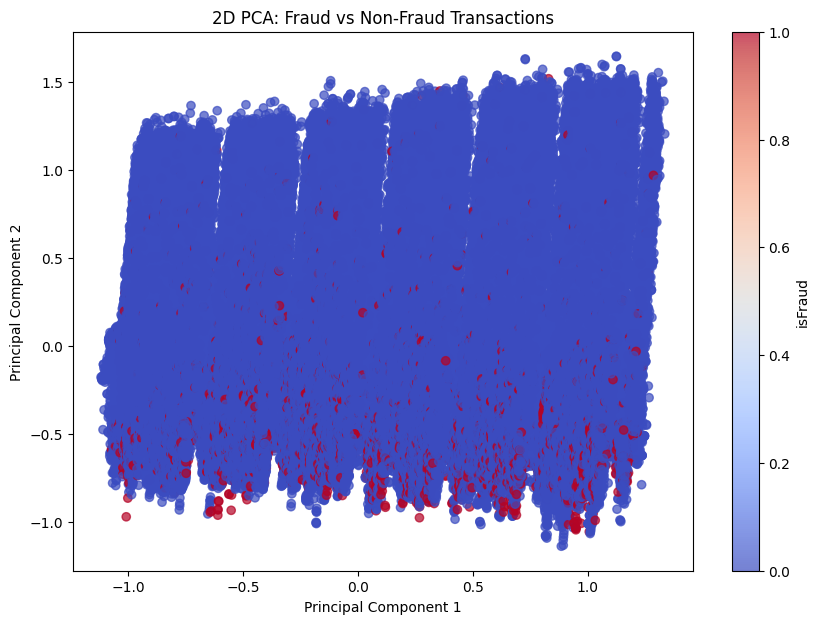

In [4]:
x2D = numeric_cols_train.fillna(numeric_cols_train.mean())
x2D = x2D.drop(['isFraud'], axis=1)  # Drop the 'isFraud' column from X
y2D = trainDF['isFraud']  # Target variable
X2D_scaled = MinMaxScaler().fit_transform(x2D)

pca = PCA(n_components=2)
PCA_components_2D = pca.fit_transform(X2D_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")

plt.figure(figsize=(10, 7))
plt.scatter(PCA_components_2D[:, 0], PCA_components_2D[:, 1], c=y2D, cmap='coolwarm', alpha=0.7)
plt.title('2D PCA: Fraud vs Non-Fraud Transactions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='isFraud')  # Add a color bar to distinguish fraud/non-fraud
plt.show()
#The PCA analysis shows that the first principal component explains 25.55% of the variance, while the second principal component explains 10.04%, resulting in a total explained variance of 35.59%. 
#This indicates that these two components capture a moderate amount of the variation in the data, 
#which may help distinguish between fraud and non-fraud transactions in the visualized 2D space

# -------------------------------------------------------------------------------------

# Isolation Forest Anomyaly Detection

In [5]:
# Create Isolation Forest and fit it based on the training data.
forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=15, verbose=0)
isolationForestTrain = numeric_cols_train.fillna(numeric_cols_train.mean())
forest.fit(isolationForestTrain)
# Generate predictions based on the Isolation Forest
predictions = forest.predict(isolationForestTrain)
print("Normal: ", np.sum(predictions == 1), "Anomalies: ", np.sum(predictions == -1))
cleaned_trainDF_Isolation = numeric_cols_train[predictions == 1]
%store cleaned_trainDF_Isolation

Normal:  531486 Anomalies:  59054
Stored 'cleaned_trainDF_Isolation' (DataFrame)


# -------------------------------------------------------------------------------------

# Mahalanobis Outlier Detection

In [6]:
numeric_cols_train = trainDF.select_dtypes('number')
numeric_cols_train = numeric_cols_train.fillna(numeric_cols_train.mean())
cov_matrix = np.cov(numeric_cols_train.values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_values = numeric_cols_train.mean(axis=0).values
mahalanobis_distances = numeric_cols_train.apply(lambda row: mahalanobis(row, mean_values, inv_cov_matrix), axis=1)
numeric_cols_train['Mahalanobis_Distance'] = mahalanobis_distances
threshold = np.percentile(mahalanobis_distances, 97.5)
numeric_cols_train['Is_Outlier'] = numeric_cols_train['Mahalanobis_Distance'] > threshold
outliers = numeric_cols_train[numeric_cols_train['Is_Outlier'] == True]
outlier_count = numeric_cols_train['Is_Outlier'].sum()

/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1035: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_10130/212830275.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  numeric_cols_train['Mahalanobis_Distance'] = mahalanobis_distances
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_10130/212830275.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  numeric_cols_train['Is_Outlier'] = numeric_cols_

In [7]:
cleaned_trainDF_Mahalanobis = numeric_cols_train[numeric_cols_train['Is_Outlier'] == False]
cleaned_trainDF_Mahalanobis = cleaned_trainDF_Mahalanobis.drop(columns=['Mahalanobis_Distance', 'Is_Outlier'])
%store cleaned_trainDF_Mahalanobis

Stored 'cleaned_trainDF_Mahalanobis' (DataFrame)
